# Setup

In [ ]:
!pip install optuna

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import glob
import numpy as np
import os
import pandas as pd
import random

import matplotlib.pyplot as plt

import optuna

In [ ]:
# Check if a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # Use the first GPU
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: Tesla T4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset

In [ ]:
class SpeedDataset(Dataset):
    def __init__(self, directory_paths, sequence_length):
        sequences, labels, timestamps = self.load_data_from_directories(directory_paths)
        self.data = torch.tensor(sequences, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)
        self.timestamps = timestamps

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

    def load_data_from_directories(self, directory_paths):
        """
        Load and concatenate data from all CSV files in the specified directory.
        Return:
            np.array of all sequences,
            np.array of all labels
        """
        all_sequences = None
        all_labels = None
        for dir_path in directory_paths:
            for filename in os.listdir(dir_path):
                if filename.endswith(".csv"):
                    file_path = os.path.join(dir_path, filename)
                    data = pd.read_csv(file_path, header=None, names=['timestamp', 'x_acc', 'y_acc', 'z_acc', 'gps_speed'])
                    sequences, labels, timestamps = self.create_sequences(data, sequence_length)
                    if isinstance(all_sequences, np.ndarray) == False:
                        all_sequences = sequences
                        all_labels = labels
                        all_timestamps = timestamps
                    else:
                        all_sequences = np.concatenate((all_sequences, sequences), axis=0)
                        all_labels = np.concatenate((all_labels, labels), axis=0)
                        all_timestamps = np.concatenate((all_timestamps, timestamps), axis=0)
        return all_sequences, all_labels, all_timestamps

    def create_sequences(self, data, sequence_length):
        """
        Create sequences and labels from the data.
        Each sequence consists of `sequence_length` rows, and the label is the GPS speed of the last row in each sequence.
        """
        sequences = []
        labels = []
        timestamps = []

        for i in range(len(data) - sequence_length):
            seq = data.iloc[i:i+sequence_length][['x_acc', 'y_acc', 'z_acc']].values
            label = data.iloc[i:i+sequence_length]['gps_speed'].mean()
            sequences.append(seq)
            labels.append(label)
            timestamps.append(data.iloc[i]['timestamp'])

        return np.array(sequences), np.array(labels), np.array(timestamps)



In [ ]:
# Create training and testing datasets
train_dir = ['/content/drive/Shareddrives/CS229/Data/FinalSplits/train_axel/']
eval_dir = ['/content/drive/Shareddrives/CS229/Data/FinalSplits/eval_axel/']
test_dir = ['/content/drive/Shareddrives/CS229/Data/FinalSplits/test_axel/']

sequence_length = 40
batch_size = 32

train_dataset = SpeedDataset(train_dir, sequence_length)
eval_dataset = SpeedDataset(eval_dir, sequence_length)
train_and_eval_dataset = SpeedDataset(train_dir + eval_dir, sequence_length)
test_dataset = SpeedDataset(test_dir, sequence_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)
train_and_eval_loader = DataLoader(train_and_eval_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Data Loader

# Model

In [ ]:
# Model hyper-parameters
model_type = 'LSTM' # 'LSTM' or 'GRU'
input_size = 3      # Number of features in input
hidden_size = 30    # Number of hidden units
num_layers = 1      # Number of layers
output_size = 1     # Number of output units (for regression)

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRU, self).__init__()
        self.hidden_size  = hidden_size
        self.num_layers = num_layers

        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# Optimize Hyperparameters (not actually used here)



In [ ]:
def objective(trial):
    # Define the hyperparameters to optimize
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)

    # Instantiate the model
    model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)

    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Load training data
    X_train_tensor = train_dataset.data.to(device)
    y_train_tensor = train_dataset.labels.to(device)

    # Load evaluation data
    X_eval_tensor = eval_dataset.data.to(device)
    y_eval_tensor = eval_dataset.labels.to(device)

    # Training loop with early stopping
    max_epochs = 10000
    patience = 3
    best_eval_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(max_epochs):
        # Training
        model.train()
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            X_tensor = X_batch.to(device)
            y_tensor = y_batch.to(device)

            # Forward pass
            predictions = model(X_tensor)
            predictions = torch.squeeze(predictions)
            loss = criterion(predictions, y_tensor)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            eval_predictions = model(X_eval_tensor)
            eval_predictions = torch.squeeze(eval_predictions)
            eval_loss = criterion(eval_predictions, y_eval_tensor)

        # Check for improvement
        if eval_loss.item() < best_eval_loss:
            best_eval_loss = eval_loss.item()
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        # Early stopping check
        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{max_epochs}, Eval Loss: {eval_loss.item():.4f}")

    return best_eval_loss


In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)
print("Best Hyperparameters:", study.best_params)

# Final training


In [ ]:
# Use best hyperparameters
# lr = study.best_params["learning_rate"]
lr = 0.001

if model_type == 'LSTM':
    model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)
elif model_type == 'GRU':
    model = GRU(input_size, hidden_size, num_layers, output_size).to(device)
else:
    raise ValueError("model_type should be either 'LSTM' or 'GRU'")

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop with early stopping
max_epochs = 1000
best_eval_loss = float('inf')
patience = 2


for epoch in range(max_epochs):
    model.train()
    total_train_loss = 0.0
    # Training
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        X_tensor = X_batch.to(device)
        y_tensor = y_batch.to(device)

        # Forward pass
        predictions = model(X_tensor)
        predictions = torch.squeeze(predictions)
        loss = criterion(predictions, y_tensor)
        total_train_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)

    model.eval()
    with torch.no_grad():
        total_eval_loss = 0
        for eval_sequences, eval_labels in eval_loader:
            eval_sequences, eval_labels = eval_sequences.to(device), eval_labels.to(device)
            eval_output = model(eval_sequences)

            eval_loss = criterion(eval_output.squeeze(), eval_labels)
            total_eval_loss += eval_loss.item()

        avg_eval_loss = total_eval_loss / len(eval_loader)

         # Print progress
        print(f"Epoch {epoch+1}/{max_epochs}, Train loss: {avg_train_loss:.4f}, Eval Loss: {avg_eval_loss:.4f}")


        if avg_eval_loss < best_eval_loss:
            best_eval_loss = avg_eval_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        # Early stopping check
        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break


# Evaluation

### Calculate Metrics


In [ ]:
model.eval()

predicted_train = model(train_and_eval_dataset.data.to(device)).detach()
predicted_train = torch.squeeze(predicted_train).to(device)

predicted_test = model(test_dataset.data.to(device)).detach()
predicted_test = torch.squeeze(predicted_test).to(device)

mse_train = (np.square(predicted_train.to("cpu") - train_and_eval_dataset.labels.numpy())).mean(axis=0)
mse_test = (np.square(predicted_test.to("cpu") - test_dataset.labels.numpy())).mean(axis=0)

print(f"MSE Train: {mse_train}")
print(f"MSE Test: {mse_test}")

model.eval()
with torch.no_grad():
    total_eval_loss = 0
    for sequences, labels in eval_loader:
        sequences, labels = sequences.to(device), labels.to(device)
        outputs = model(sequences)
        loss = criterion(outputs.squeeze(), labels)
        total_eval_loss += loss.item()

    avg_eval_loss = total_eval_loss / len(eval_loader)
    print(f"Val Loss: {avg_eval_loss:.4f}")

    total_test_loss = 0
    for sequences, labels in test_loader:
        sequences, labels = sequences.to(device), labels.to(device)
        outputs = model(sequences)
        loss = criterion(outputs.squeeze(), labels)

        total_test_loss += loss.item()

    avg_test_loss = total_test_loss / len(test_loader)
    print(f"Test Loss: {avg_test_loss:.4f}")

### Plot

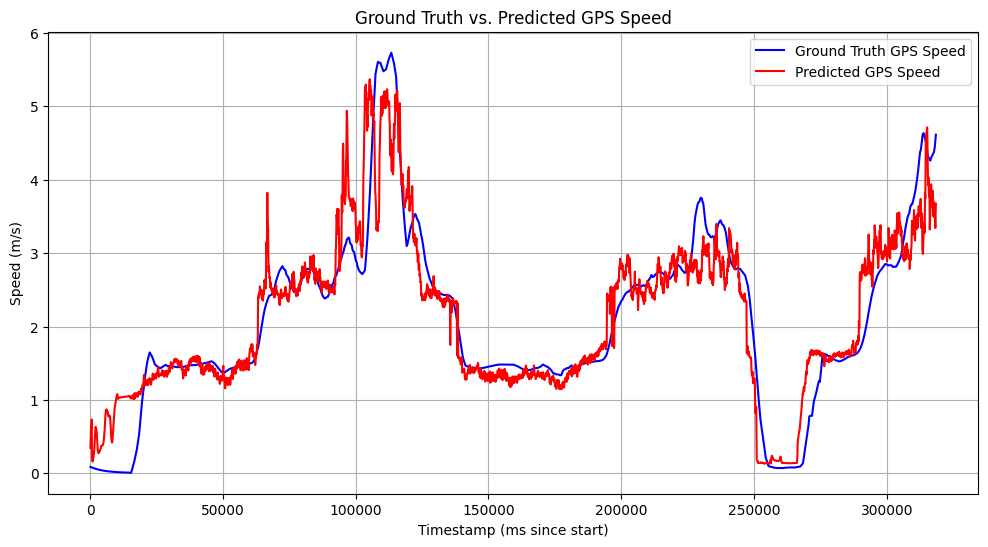

In [ ]:
predicted_test = model(test_dataset.data.to(device)).detach().to("cpu").numpy()

plt.figure(figsize=(12, 6))
plt.plot(test_dataset.timestamps, test_dataset.labels, label='Ground Truth GPS Speed', color='blue')
plt.plot(test_dataset.timestamps, predicted_test, label='Predicted GPS Speed', color='red')
# plt.plot(test_dataset.timestamps, test_dataset.data.sum(dim=1) / 8, label='Combined magnitudes', color='green')
plt.xlabel('Timestamp (ms since start)')
plt.ylabel('Speed (m/s)')
plt.title('Ground Truth vs. Predicted GPS Speed')
plt.legend()
plt.grid(True)
plt.show()